<div style="text-align: center; color: #9900cc; font-family: 'Montserrat', sans-serif; font-size: 36px; font-weight: bold;">Segmentez des clients d'un site e-commerce</div>

# Mission

La mission principale consiste à répondre à la demande d'Olist en fournissant à ses équipes d'e-commerce une segmentation détaillée des clients. Cette segmentation leur permettra d'optimiser leurs campagnes de communication quotidiennes.

Pour atteindre cet objectif, voici les tâches à accomplir :

    1.Analyser le comportement et les données personnelles des utilisateurs afin de saisir les différents profils.
    
    2.Présenter à l'équipe Marketing une segmentation claire et opérationnelle, accompagnée d'une explication détaillée de 
    sa logique sous-jacente pour une utilisation efficace.

    3.Proposer un contrat de maintenance qui garantira la stabilité des segments au fil du temps. Cette proposition reposera sur une analyse approfondie de l'évolution des segments au fil du temps.

# Importation des bibliothèques nécessaires

Dans ce notebook, nous entreprendrons une analyse exploratoire des données dans le but de mieux comprendre notre ensemble de données et de sélectionner les caractéristiques les plus importantes. Le processus est divisé en trois étapes distinctes :

    1.Agrégation des données : Cette étape consistera à regrouper les données pertinentes et à les préparer pour l'analyse.

    2.Sélection des caractéristiques : Nous procéderons à une analyse approfondie pour choisir les caractéristiques les plus significatives qui influencent nos objectifs d'analyse.

    3.Exploration des données : Enfin, nous explorerons les données sélectionnées pour en extraire des insights et des        tendances importantes.

In [53]:
import pandas as pd 
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Regroupement des données

Dans ce notebook, nous entreprendrons le regroupement de données à partir de plusieurs fichiers de notre jeu de données. Voici un aperçu du contenu de chaque fichier :

    customers : Ce fichier contient des informations sur les clients, telles que leur identifiant etc.
    
    geoloc : Il contient des données de géolocalisation des clients, y compris leur latitude et leur longitude.
    
    order_items : Ce fichier comprend les détails des articles commandés, tels que l'identifiant de la commande,
    l'identifiant du produit, la quantité commandée, le prix, etc.
    
    order_pymts : Il contient des informations sur les paiements associés aux commandes, tels que l'identifiant de la commande, le montant payé, la méthode de paiement, etc.
    
    order_reviews : Ce fichier contient les évaluations et les commentaires laissés par les clients pour leurs commandes.
    
    orders : Il comprend des détails sur les commandes passées par les clients, tels que l'identifiant de 
    la commande, la date de commande, le statut de la commande, etc.
    
    products : Ce fichier contient des informations sur les produits disponibles à l'achat, tels que leur identifiant, leur nom, leur catégorie, leur prix, etc.
    
    sellers : Il comprend des détails sur les vendeurs, tels que leur identifiant, leur évaluation moyenne, etc.
    
    translation : Ce fichier contient des traductions pour certaines données, ce qui peut être utile pour l'analyse 
    multilingue.

Nous utiliserons des opérations de jointure SQL pour combiner ces fichiers de manière à créer une vue d'ensemble complète de nos données, facilitant ainsi leur analyse ultérieure.

In [6]:
conn = sqlite3.connect('olist.db')

In [7]:
# Définir votre requête SQL
query = '''
SELECT *
FROM customers c
LEFT JOIN orders o ON c.customer_id = o.customer_id
LEFT JOIN order_items ot ON ot.order_id = o.order_id
LEFT JOIN order_pymts op ON op.order_id = o.order_id
LEFT JOIN order_reviews orv ON orv.order_id = o.order_id
LEFT JOIN products p ON ot.product_id = p.product_id
LEFT JOIN translation t ON p.product_category_name = t.product_category_name
GROUP BY c.customer_id
'''

# Exécuter la requête SQL et stocker les résultats dans un DataFrame
df = pd.read_sql_query(query, conn)

# Exporter le DataFrame vers un fichier CSV
df.to_csv('Dataframe1.csv', index=False)

conn.close()                                                                                                                                                                                                                                                                                                     

# Compréhension des données

In [8]:
data=pd.read_csv('Dataframe1.csv')

In [9]:
data.columns

Index(['index', 'customer_id', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'index.1', 'order_id', 'customer_id.1', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'index.2', 'order_id.1',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'index.3', 'order_id.2', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'index.4',
       'review_id', 'order_id.3', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'index.5', 'product_id.1',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm

## Nettoyages des données 

### supprimer les colonnes non nécessaires

Dans ce cas, nous allons supprimer les colonnes contenant les clés primaires 'customer_id.1', 'index.2', 'order_id.1', 'index.3', 'index.4', 'index.5' et 'product_id.1' des données agrégées. Ces colonnes ne sont pas nécessaires car elles représentent des identifiants redondants ou des index de données. La suppression de ces colonnes contribuera à nettoyer et à simplifier notre ensemble de données consolidé.

In [10]:
data=data.drop(['index','index.1','customer_id.1','index.2','order_id.1','index.3','order_id.2',
                'index.4','order_id.3','index.5','product_id.1','index.6', 'product_category_name.1'],axis=1).reset_index()

### Choix des caractéristiques 

Premièrement, les colonnes telles que 'order_approved_at', 'order_delivered_carrier_date', et autres, contiennent des informations liées à la logistique des commandes, qui ne sont pas directement liées à la segmentation des utilisateurs ou des produits. Leur exclusion simplifie l'ensemble de données en se concentrant sur les attributs significatifs pour la segmentation. Deuxièmement, en supprimant les colonnes redondantes, comme celles relatives aux dimensions des produits ou aux informations de révision, nous éliminons le chevauchement d'informations et favorisons une analyse plus précise. Troisièmement, cela permet de gérer les données manquantes ou peu fiables présentes dans certaines colonnes, améliorant ainsi la qualité de l'analyse de segmentation.La suppression de ces colonnes non pertinentes ou redondantes vise à simplifier et à optimiser le processus de segmentation en se concentrant sur les attributs essentiels qui influent directement sur les comportements des utilisateurs et sur la catégorisation des produits sur le site e-commerce.

In [11]:
data= data.drop(['order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date','product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm','review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp','customer_id','product_id','order_item_id','seller_id','review_id',],axis=1)

# Déscription et nettoyages des données

In [13]:
data.head()

,index,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name,product_category_name_english
0,0,248ffe10d632bebe4f7267f1f44844c9,6273,osasco,SP,5f79b5b0931d63f1a42989eb65b9da6e,delivered,2017-11-14 16:08:26,2017-11-21 16:35:32,89.80,24.94,1.0,credit_card,8.0,114.74,1.0,brinquedos,toys
1,1,b0015e09bb4b6e47c52844fab5fb6638,35550,itapecerica,MG,a44895d095d7e0702b6a162fa2dbeced,delivered,2017-07-16 09:40:32,2017-07-20 09:55:12,54.90,12.51,1.0,credit_card,5.0,67.41,4.0,beleza_saude,health_beauty
2,2,94b11d37cd61cb2994a194d11f89682b,29830,nova venecia,ES,316a104623542e4d75189bb372bc5f8d,delivered,2017-02-28 11:06:43,2017-03-06 11:15:20,179.99,15.43,1.0,credit_card,10.0,195.42,5.0,bebes,baby
3,3,4893ad4ea28b2c5b3ddf4e82e79db9e6,39664,mendonca,MG,5825ce2e88d5346438686b0bba99e5ee,delivered,2017-08-16 13:09:20,2017-08-23 03:10:27,149.90,29.45,1.0,boleto,1.0,179.35,5.0,cool_stuff,cool_stuff
4,4,0b83f73b19c2019e182fd552c048a22c,4841,sao paulo,SP,0ab7fb08086d4af9141453c91878ed7a,delivered,2018-04-02 13:42:17,2018-04-10 03:10:19,93.00,14.01,1.0,boleto,1.0,107.01,4.0,cama_mesa_banho,bed_bath_table


In [19]:
data.shape

(99441, 18)

Notre jeu de données contient 18 colonnes et 994441 lignes.

In [12]:
data.describe()

,index,customer_zip_code_prefix,price,freight_value,payment_sequential,payment_installments,payment_value,review_score
count,99441.000000,99441.000000,98666.000000,98666.000000,99440.000000,99440.000000,99440.000000,98673.000000
mean,49720.000000,35137.474583,125.964327,20.201927,1.022878,2.915617,158.334781,4.086853
std,28706.288396,29797.938996,191.375106,15.909873,0.250282,2.709861,219.518488,1.347287
min,0.000000,1003.000000,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,24860.000000,11347.000000,41.505000,13.310000,1.000000,1.000000,60.050000,4.000000
50%,49720.000000,24416.000000,79.000000,16.360000,1.000000,2.000000,103.350000,5.000000
75%,74580.000000,58900.000000,139.900000,21.230000,1.000000,4.000000,175.130000,5.000000
max,99440.000000,99990.000000,6735.000000,409.680000,27.000000,24.000000,13664.080000,5.000000


## Valeurs manquantes

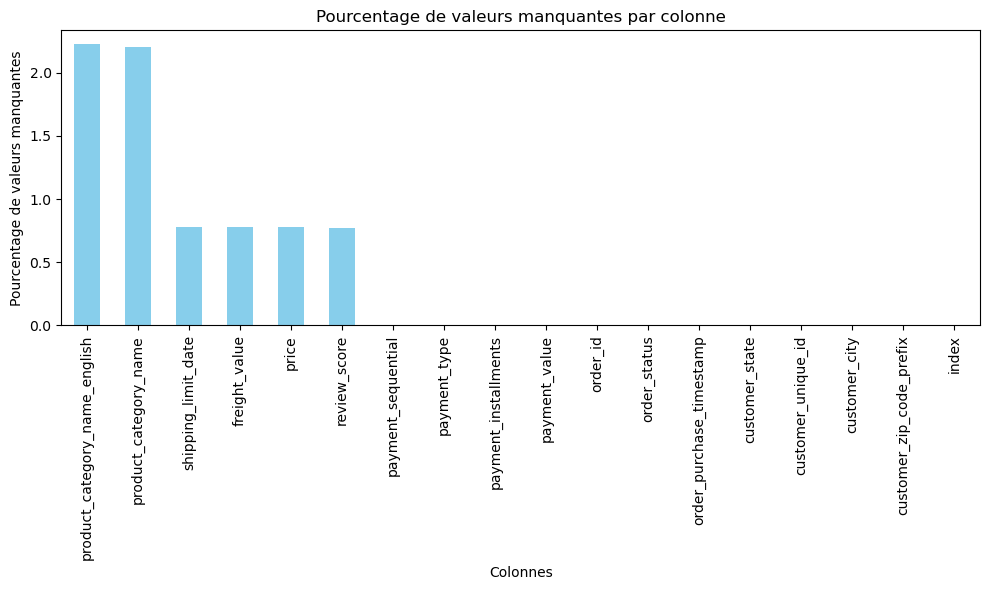

In [17]:
#Calculer le pourcentage
missing_values_percentage = (data.isnull().mean()) * 100
missing_values_percentage = missing_values_percentage.sort_values(ascending=False)
#Tracer le graphe
plt.figure(figsize=(10, 6))
missing_values_percentage.plot(kind='bar', color='skyblue')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de valeurs manquantes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Nous observons qu'il n'y a que six lignes contenant des valeurs manquantes. Étant donné que notre objectif principal ne concerne pas le nettoyage des données, nous allons simplement supprimer ces valeurs manquantes.

In [20]:
#Supprimer les valeurs manquantes
data=data.dropna()

## Lignes dupliquées

In [24]:
#Verifier s'il y a des lignes dupliquée
duplicate_lignes = data.duplicated().any()

if duplicate_lignes:
    print("Il y a des lignes dupliquées dans le DataFrame.")
else:
    print("Il n'y a pas de lignes dupliquées dans le DataFrame.")

Il n'y a pas de lignes dupliquées dans le DataFrame.


## Convertir les colonnes de dates en format datetime

In [29]:
## Convertir colonnes en datetime
date_convert = ['order_purchase_timestamp']
for col in date_convert:
    data[col] = pd.to_datetime(data[col])

C:\Users\HP\AppData\Local\Temp\ipykernel_8424\2652293375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_datetime(data[col])


# RFM

## Définition

Nous commençons notre analyse exploratoire par RFM.  
Le RFM (Récence, Fréquence, Montant) est une méthode d'analyse du comportement client largement utilisée dans le domaine du marketing et de la gestion de la relation client (CRM). Elle repose sur trois dimensions principales :

    Récence (Recency) : Cette dimension mesure la proximité temporelle de la dernière interaction d'un client avec        l'entreprise. Plus précisément, elle évalue depuis combien de temps il est passé depuis la dernière transaction, 
    la dernière visite sur le site web, ou toute autre action pertinente pour l'entreprise.

    Fréquence (Frequency) : La fréquence mesure à quelle fréquence un client interagit avec l'entreprise sur une période 
    donnée. Cela peut être le nombre total de transactions effectuées, le nombre de visites sur le site web, ou d'autres 
    actions pertinentes pour l'entreprise.

    Montant (Monetary) : Cette dimension évalue la valeur monétaire totale des transactions effectuées par un client sur une période donnée. Cela peut inclure le montant total dépensé, la valeur moyenne des transactions, ou d'autres mesures 
    financières importantes.

## Recency

In [30]:
#Détermination de la derniere date d'achat
data_recency = data.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
#Création de dataframe
data_recency.columns = ['customer_unique_id', 'LastPurchaseDate']
recent_date = data_recency['LastPurchaseDate'].max()
#Calcul de la récence
data_recency['Recency'] = data_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
data_recency.head()

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292


prenons par exemple ce client (avec l'identifiant 0000366f3b9a7992bf8c76cfdf3221e2) a interagi pour la dernière fois avec l'entreprise le 10 mai 2018 à 10h56m27s, et qu'il s'est écoulé 115 jours depuis cette interaction.

En interprétant cette récence, on peut dire que ce client n'a pas interagi avec l'entreprise depuis 115 jours, ce qui peut indiquer une inactivité prolongée ou un manque d'engagement récent avec les produits ou services de l'entreprise.

## Frequency

In [31]:
#Calcul de nombre de connexion par chaque client
nombre_de_connexions_par_client =data.groupby('customer_unique_id')['order_purchase_timestamp'].count()
#Creation de dataframe fréquence
frequency_data = pd.DataFrame({'customer_unique_id': nombre_de_connexions_par_client.index,
                             'Frequency': nombre_de_connexions_par_client.values})

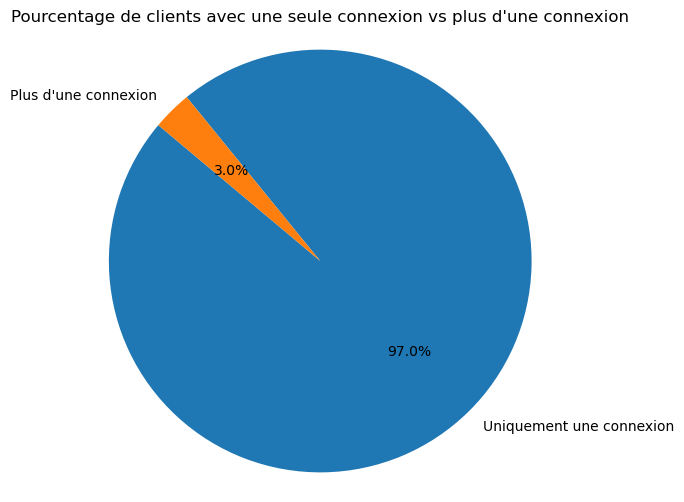

In [33]:
#Nombre de client qui font une connexion
nombre_clients_une_connexion = frequency_data[frequency_data['Frequency'] == 1]['Frequency'].count()
#Supérieur d'une connexion
nombre_clients_plus_dune_connexion = frequency_data[frequency_data['Frequency'] > 1]['Frequency'].count()
#Calcule de pourcentage
pourcentage_une_connexion = nombre_clients_une_connexion / len(frequency_data) * 100
pourcentage_plus_dune_connexion = nombre_clients_plus_dune_connexion / len(frequency_data) * 100
# Graphe
labels = ['Uniquement une connexion', 'Plus d\'une connexion']
valeurs = [pourcentage_une_connexion, pourcentage_plus_dune_connexion]
plt.figure(figsize=(6, 6))
plt.pie(valeurs, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Pourcentage de clients avec une seule connexion vs plus d\'une connexion')
plt.show()

Nous observons que seulement 3 % des clients ont effectué plusieurs connexions au site.Cela suggère que la majorité des clients n'ont pas une fréquence élevée de connexion au site. Ils peuvent être des utilisateurs occasionnels ou ne pas avoir un besoin fréquent d'accès au site. Cette information peut être utile pour comprendre le comportement des clients et pour adapter les stratégies de marketing et de fidélisation en conséquence. 

## Monetary

In [34]:
#Calcul du montant
monetary = data.groupby('customer_unique_id')['payment_value'].sum().reset_index()
monetary.columns = ['customer_unique_id', 'monetary']

In [35]:
monetary.head()

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


Ces données peuvent être utilisées pour évaluer la valeur monétaire des transactions effectuées par chaque client sur le site e-commerce. Cela peut être utile pour identifier les clients les plus précieux ou les segments de clientèle à fort potentiel de dépenses.  
Par exemple:  
0000366f3b9a7992bf8c76cfdf3221e2 : Ce client a réalisé des transactions pour un montant total de 141,90 unités monétaires.
0000b849f77a49e4a4ce2b2a4ca5be3f : Ce client a réalisé des transactions pour un montant total de 27,19 unités monétaires.

## Merger les données RFM

In [56]:
df1=data_recency[['customer_unique_id','Recency']]
df2=frequency_data['Frequency']
df3=monetary['monetary']
RFM_data=pd.concat([df1,df2,df3], axis=1)

In [37]:
RFM_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93372 entries, 0 to 93371
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93372 non-null  object 
 1   Recency             93372 non-null  int64  
 2   Frequency           93372 non-null  int64  
 3   monetary            93372 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


In [57]:
RFM_data.to_csv('RFM.csv', index=False)

# Analyse exploratoire


À présent que nous avons une compréhension globale du comportement de chaque client grâce à l'analyse RFM, nous allons explorer en profondeur notre ensemble de données dans son intégralité.

## Nombre de commande par mois

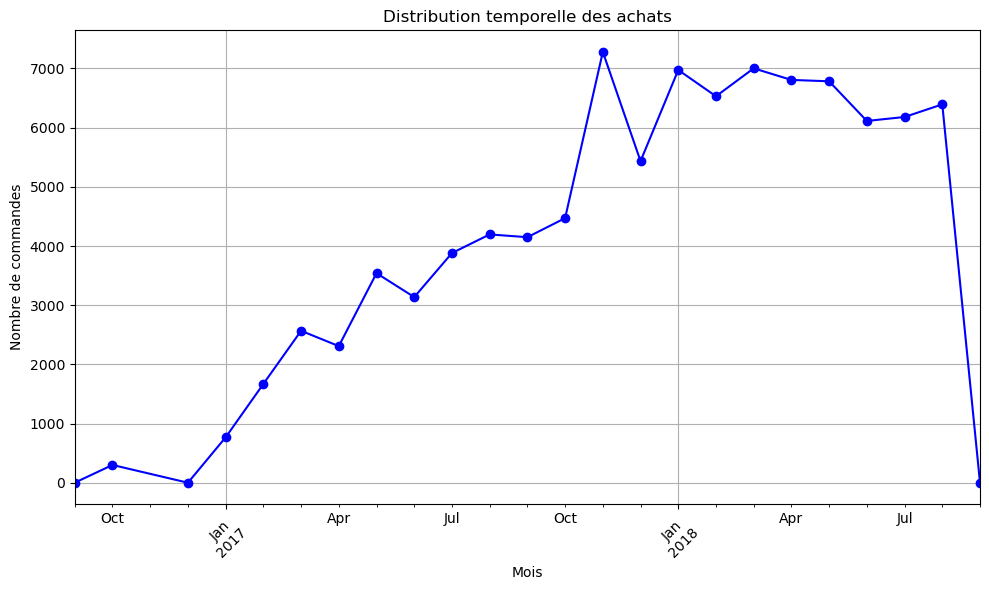

In [38]:
#convertir les dates en périodes de mois
data['year_month'] = data['order_purchase_timestamp'].dt.to_period('M')
#Ordre par mois
orders_per_month = data['year_month'].value_counts().sort_index()
#Tracer le graphe
plt.figure(figsize=(10, 6))
orders_per_month.plot(kind='line', marker='o', color='b')
plt.title('Distribution temporelle des achats')
plt.xlabel('Mois')
plt.ylabel('Nombre de commandes')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sur notre site, les achats connaissent une période de forte activité entre les mois de novembre et de mai.

## nombre de commande par chaque client


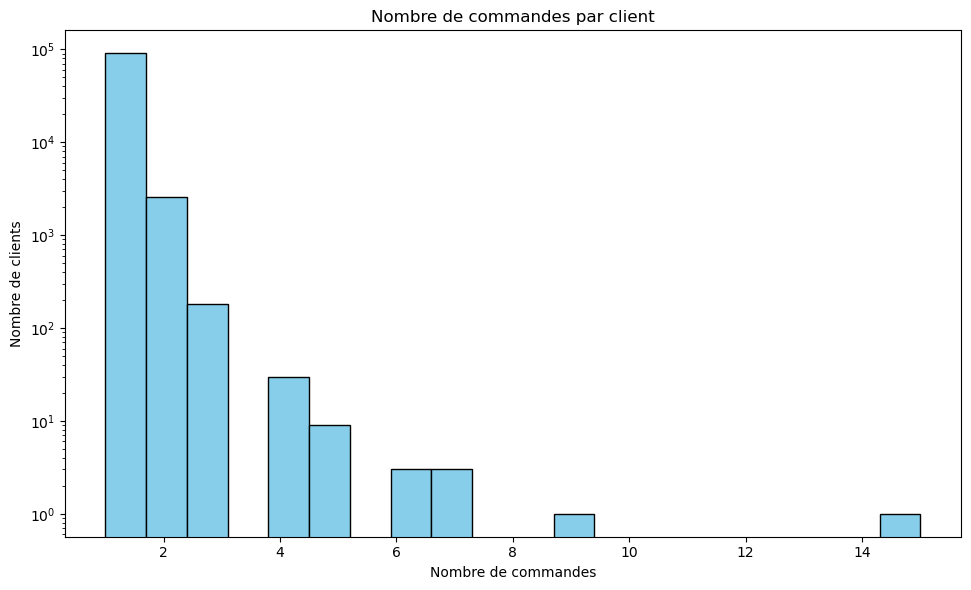

In [39]:
#Calcul d'ordre par client
orders_par_client = data['customer_unique_id'].value_counts()
#Graphe
plt.figure(figsize=(10, 6))
orders_par_client.hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Nombre de commandes par client')
plt.xlabel('Nombre de commandes')
plt.ylabel('Nombre de clients')
plt.grid(False)
plt.tight_layout()
plt.yscale('log')
plt.show()

Il est remarquable que la majorité des clients ont effectué des commandes entre une et deux fois, tandis qu'un petit nombre de clients ont passé plus de trois commandes.

## Répartition des client par code postale


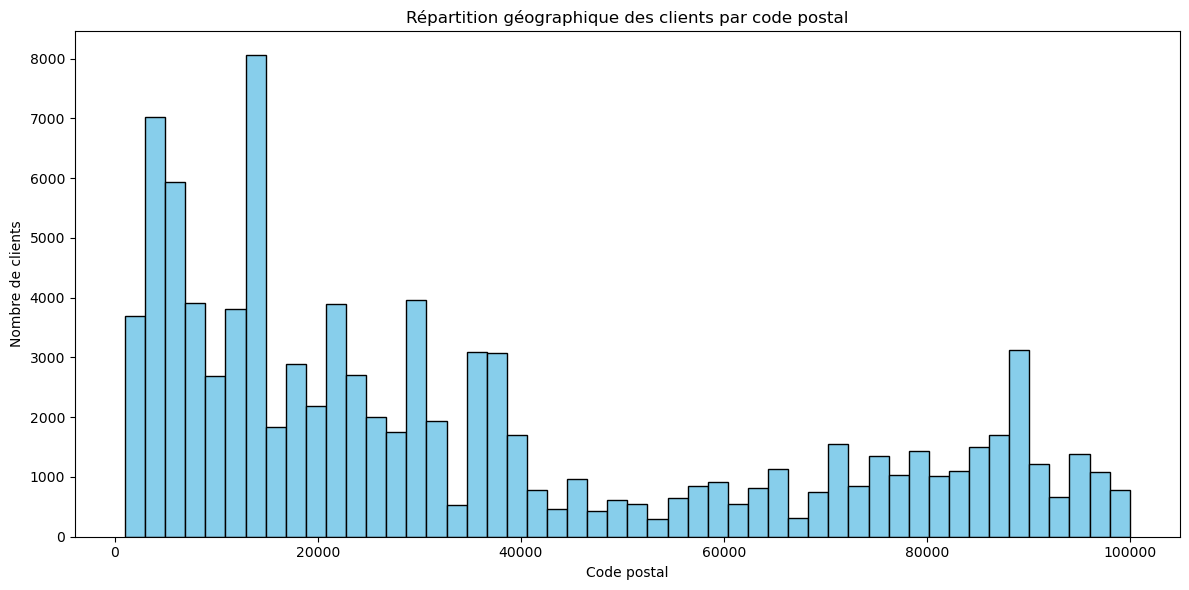

In [40]:
plt.figure(figsize=(12, 6))
data['customer_zip_code_prefix'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Répartition géographique des clients par code postal')
plt.xlabel('Code postal')
plt.ylabel('Nombre de clients')
plt.grid(False)
plt.tight_layout()
plt.show()

Il est apparent que la majorité des clients résident dans les régions dont les codes postaux sont compris entre 0 et 20000, dépassant ainsi le nombre de clients résidant dans les autres zones géographiques.

 ## Mode de paiement

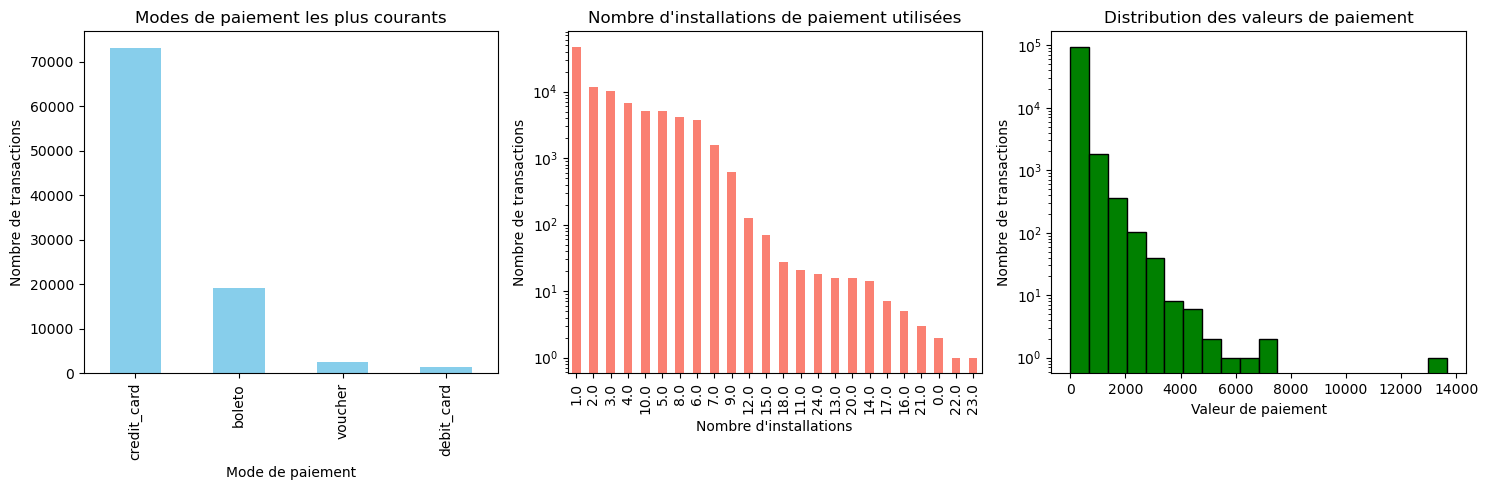

In [41]:
#mode de paiement 
top_payment_modes = data['payment_type'].value_counts()
# nombre de fois utilisées
num_payment_installments = data['payment_installments'].value_counts()
#Montant payée
payment_values = data['payment_value']
#graphes
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
top_payment_modes.plot(kind='bar', color='skyblue')
plt.title('Modes de paiement les plus courants')
plt.xlabel('Mode de paiement')
plt.ylabel('Nombre de transactions')

plt.subplot(1, 3, 2)
num_payment_installments.plot(kind='bar', color='salmon')
plt.title('Nombre d\'installations de paiement utilisées')
plt.xlabel('Nombre d\'installations')
plt.ylabel('Nombre de transactions')
plt.yscale('log')

plt.subplot(1, 3, 3)
plt.hist(payment_values, bins=20, color='green', edgecolor='black')
plt.title('Distribution des valeurs de paiement')
plt.xlabel('Valeur de paiement')
plt.ylabel('Nombre de transactions')
plt.yscale('log')

plt.tight_layout()
plt.show()

Nous remarquons que la méthode de paiement par carte de crédit est la plus couramment utilisée, et que la plupart des montants payés sont inférieurs à 3000.

## Review Score 

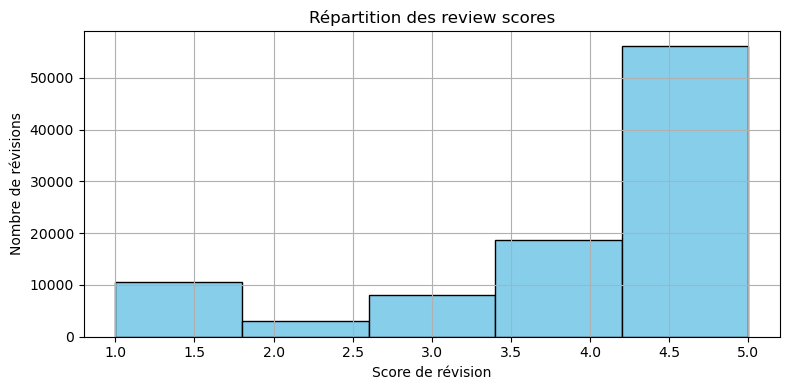

In [43]:
plt.figure(figsize=(8, 4))
plt.hist(data['review_score'], bins=5, color='skyblue', edgecolor='black')
plt.title('Répartition des review scores')
plt.xlabel('Score de révision')
plt.ylabel('Nombre de révisions')
plt.grid(True)
plt.tight_layout()
plt.show()

La majorité des scores de revue sont positifs, se situant généralement entre 4.2 et 5.

## Les Produits les plus populaires


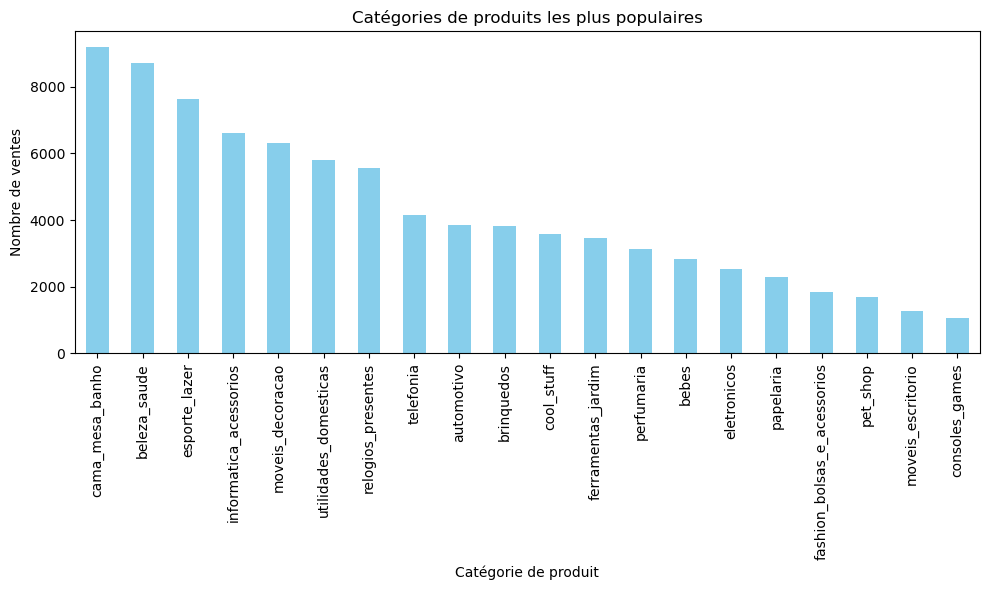

In [44]:
#Calcul des produits vendues
top_categories = data['product_category_name'].value_counts().head(20)
#Graphe
plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar', color='skyblue')
plt.title('Catégories de produits les plus populaires')
plt.xlabel('Catégorie de produit')
plt.ylabel('Nombre de ventes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Nous observons que les produits les plus vendus sur le site sont Cama_mesa_banho, beleza_saude et esporte_lazer.

# Graphe RFM 3D

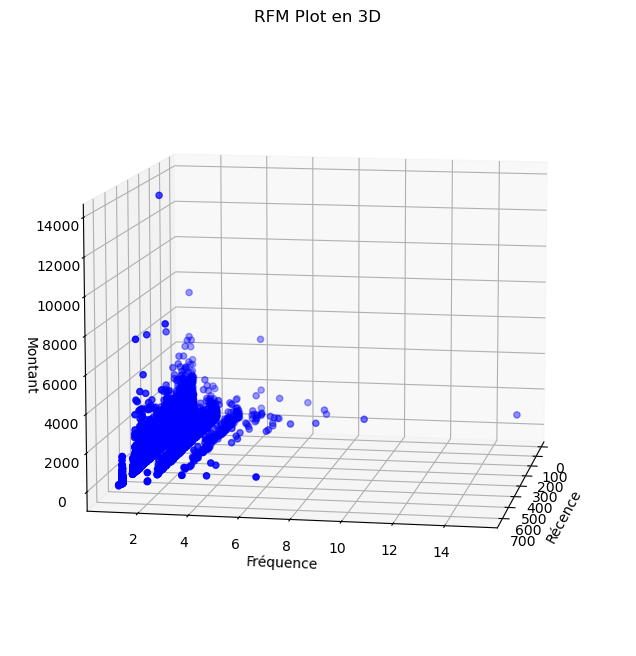

In [47]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(RFM_data['Recency'], RFM_data['Frequency'], RFM_data['monetary'], c='blue', marker='o')
ax.view_init(elev=10, azim=10)
ax.set_xlabel('Récence')
ax.set_ylabel('Fréquence')
ax.set_zlabel('Montant')
plt.title('RFM Plot en 3D')
plt.show()

D'après le graphique RFM en 3D, on observe que la plupart des clients ont effectué entre une et trois connexions, avec la majorité des montants d'achat se situant entre 0 et 4000, et une récence généralement comprise entre 0 et 400.

#  l'Analyse en Composantes Principales (PCA)

In [50]:
numerical_columns = RFM_data.select_dtypes(include='number')
#Normalisation des données
SS=StandardScaler()
X=pd.DataFrame(SS.fit_transform(numerical_columns), columns=numerical_columns.columns)

In [51]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
# convertir les données
principal_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2','PC3'])
# Shape and preview
principal_df.shape
principal_df.head()

,PC1,PC2,PC3
0,-0.056075,-0.836184,-0.130431
1,-0.413604,-0.906712,0.228247
2,-0.640708,1.856595,0.321477
3,-0.563251,0.435793,0.312608
4,-0.057465,0.343805,-0.185611


ces composants principaux fournissent une représentation simplifiée des données RFM d'origine et permettent de mieux comprendre les tendances et les structures sous-jacentes dans les comportements des clients.  

    Le premier composant principal :
        La valeur négative de la première composante principale (-0.056075) suggère une contribution négative des variables     originales à ce composant.
        Une forte charge négative sur la deuxième variable indique que ce composant est principalement influencé par 
        la   fréquence des achats.
        Cela pourrait indiquer que ce composant représente le niveau d'engagement ou d'activité des clients, où des valeurs plus négatives peuvent correspondre à des clients moins actifs ou moins engagés.

    Le deuxième composant principal :
        La valeur négative de la deuxième composante principale (-0.836184) suggère une contribution négative des variables originales à ce composant.
        Une forte charge négative sur la troisième variable indique que ce composant est principalement influencé par 
        le montant total des achats.
        Cela pourrait indiquer que ce composant représente la valeur monétaire associée aux achats des clients, où des 
        valeurs plus négatives peuvent correspondre à des clients ayant dépensé moins.

    Le troisième composant principal :
        La valeur négative de la troisième composante principale (-0.130431) suggère une contribution négative des variables originales à ce composant.
        Une charge positive sur la deuxième variable et une charge négative sur la première variable indiquent que ce 
        composant est influencé par la fréquence des achats et la récence.
        Cela pourrait indiquer que ce composant représente la récence et la fréquence des achats combinées, où des valeurs 
        plus négatives peuvent correspondre à des clients moins récents ou moins fréquents.

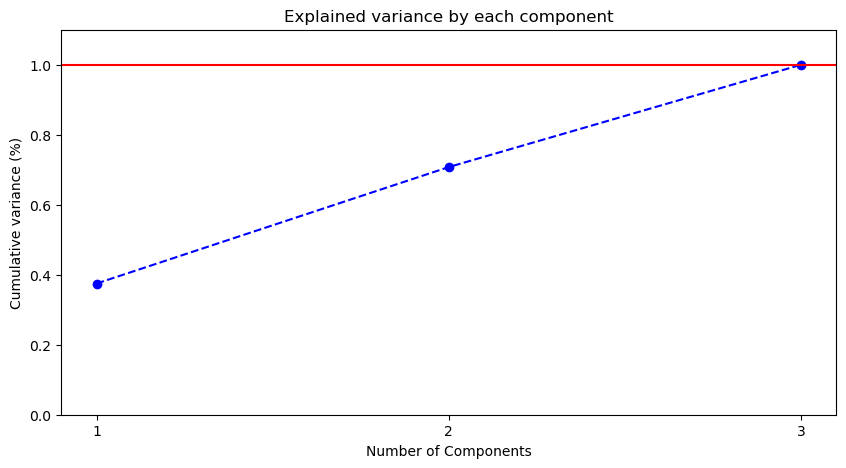

In [52]:
pca_var = PCA()
pca_var.fit(X)

# Tracer le graphe
plt.figure(figsize=(10,5))
xi = np.arange(1, 1+X.shape[1], step=1)
yi = np.cumsum(pca_var.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=1))
plt.ylabel('variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.gca().xaxis.grid(False)

    Premier composant principal (PC1) avec une variance de 0.4 :
        Étant donné que la variance de PC1 est de 0.4, cela signifie que PC1 capture 40 % de la variance totale dans 
        les données.
        PC1 est le principal contributeur à la variation observée dans les données.

    Deuxième composant principal (PC2) avec une variance de 0.7 :
        Avec une variance de 0.7, PC2 capture 70 % de la variance totale dans les données.
        PC2 est également un contributeur significatif à la variation observée dans les données, mais il capture moins 
        de variance que PC1.

    Troisième composant principal (PC3) avec une variance de 1.0 (ou 100 %) :
        Avec une variance de 1.0, PC3 capture 100 % de la variance totale dans les données.
        PC3 capture la totalité de la variation dans les données, ce qui signifie que les deux premiers composants principaux (PC1 et PC2) ne sont pas nécessaires pour expliquer la variation dans les données une fois PC3 est pris en compte.
        Dans ce cas, PC3 peut être considéré comme redondant car il capture déjà toute la variation.  

PC1 et PC2 sont importants pour expliquer la variation dans les données, tandis que PC3 ne contribue pas de manière significative une fois que PC2 est pris en compte. 

# t-SNE (t-Distributed Stochastic Neighbor Embedding)

In [54]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# convertir les données
tsne_df = pd.DataFrame(data = X_tsne, columns = ['tsne comp. 1', 'tsne comp. 2'])

print(tsne_df.shape)
tsne_df.head()

(93372, 2)


,tsne comp. 1,tsne comp. 2
0,30.162624,-56.863476
1,-80.966660,-92.848442
2,6.707575,124.212173
3,-90.531914,41.950829
4,31.373394,32.087933


    Le point 3 se trouve à une coordonnée x de -90.531914 et une coordonnée y de 41.950829.
    Le point 1 se trouve à une coordonnée x de -80.966660 et une coordonnée y de -92.848442.
    Le point 2 se trouve à une coordonnée x de 6.707575 et une coordonnée y de 124.212173.
    Le point 0 se trouve à une coordonnée x de 30.162624 et une coordonnée y de -56.863476.
    Le point 4 se trouve à une coordonnée x de 31.373394 et une coordonnée y de 32.087933.

Ces coordonnées représentent la position de chaque point dans l'espace bidimensionnel après la réduction de dimensionnalité par t-SNE.

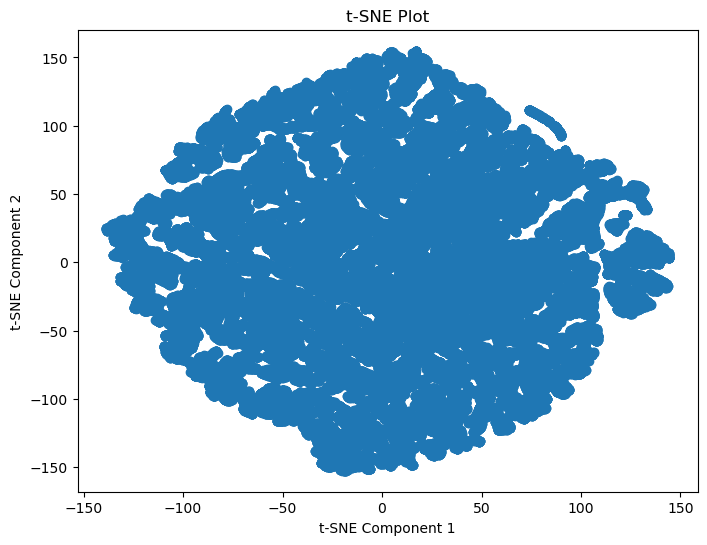

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['tsne comp. 1'], tsne_df['tsne comp. 2'])
plt.title("t-SNE Plot")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

les points qui sont proches les uns des autres dans l'espace bidimensionnel sont similaires dans l'espace d'origine, tandis que les points éloignés sont moins similaires.  
La visualisation de ces points dans le graphique ci-dessus peut nous aider à identifier des clusters, des tendances ou des structures dans les données.